## 気象情報から気象警報の有無をロジスティック回帰する

### 対象災害
2018年　西日本豪雨豪雨

2018年7月に発生した西日本豪雨は、記録的な集中豪雨による日本全国で甚大な被害をもたらした災害です。特に中国地方や四国地方で大規模な浸水や土砂災害が発生し、岡山県倉敷市真備町では広範囲が冠水しました。この災害では全国で200人以上が死亡し、住宅被害も大きな規模に及びました。要因としては、梅雨前線の停滞による長期間の降雨が挙げられ、河川 の氾濫や堤防の決壊が住民生活を直撃しました。これにより、避難計画や災害情報の重要性が再認識されました。
    

### データ場所
- 岡山県倉敷市真備町のアメダスデータ
- 高梁川の水位

### 使用変数
- 降水量データ：一時間ごとの降水量の数値データ．
- 河川水位データ：一時間ごとの河川の水位データ．
- 気象警報：一時間ごとの気象警報の有無を1/0で表した時系列データ．
- 



### 流れ
- 各データのインプットと前処理でdfを作成
    - データ数はそれぞれ168個(24時間x7日)と設定するため，dfは[168x3]のサイズを持つ
- 全体の20%をテストデータとして配分して，logisticモデルにフィットさせる．
- 予測したり，係数を確認したり．

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



In [15]:
date_st    = pd.to_datetime('2018-07-04 00:00:00')
date_en    = pd.to_datetime('2018-07-07 23:59:59')
print(date_st,'...',date_en)

2018-07-04 00:00:00 ... 2018-07-07 23:59:59


In [16]:
import pandas as pd

# waterlevel
df_wl = pd.read_pickle('./waterLevel.pickle')
df_wl = df_wl.loc[date_st:date_en]
print(df_wl.shape)

(96, 1)


In [17]:
# weather_warning
df_ww = pd.read_pickle('./warning_list.pickle')
df_ww = df_ww['combined_df'][['大雨警報','大雨注意報','雷注意報']]
df_ww = df_ww.rename(columns={'大雨警報': 'Rainstorm Warning','大雨注意報': 'Rainstorm Advisory','雷注意報':'Thunder Advisory'})
df_ww = df_ww.loc[date_st:date_en]
print(df_ww.shape)

(96, 3)


In [18]:
# precipitation
df_prec = pd.read_pickle('./weather_exo.pickle')[['prec','wind']]
df_prec = df_prec.loc[date_st:date_en]
print(df_prec.shape)

(96, 2)


In [19]:
df_new=pd.concat([df_wl,df_ww,df_prec],axis=1)
df_new['Rainstorm Advisory']=df_new['Rainstorm Advisory'].apply(lambda x:1 if x!=0 else 0)
df_new['Rainstorm Warning']=df_new['Rainstorm Warning'].apply(lambda x:1 if x!=0 else 0)
df_new['Thunder Advisory']=df_new['Thunder Advisory'].apply(lambda x:1 if x!=0 else 0)
df_new

,waterLevel,Rainstorm Warning,Rainstorm Advisory,Thunder Advisory,prec,wind
2018-07-04 00:00:00,0.65,0,0,1,0.0,3.7
2018-07-04 01:00:00,0.66,0,0,1,1.5,2.5
2018-07-04 02:00:00,0.68,0,0,1,0.5,2.2
2018-07-04 03:00:00,0.69,0,0,1,0.5,3.6
2018-07-04 04:00:00,0.72,0,0,1,2.0,1.3
...,...,...,...,...,...,...
2018-07-07 19:00:00,3.69,1,0,1,0.0,1.8
2018-07-07 20:00:00,3.59,1,0,1,0.5,0.1
2018-07-07 21:00:00,3.41,1,0,1,0.0,0.8
2018-07-07 22:00:00,3.28,1,0,1,0.0,0.8


In [20]:
(df_new['Rainstorm Warning']==1).sum()

np.int64(39)

In [21]:
(df_new['Rainstorm Warning']==0).sum()

np.int64(57)

In [28]:
len(df_new)

96

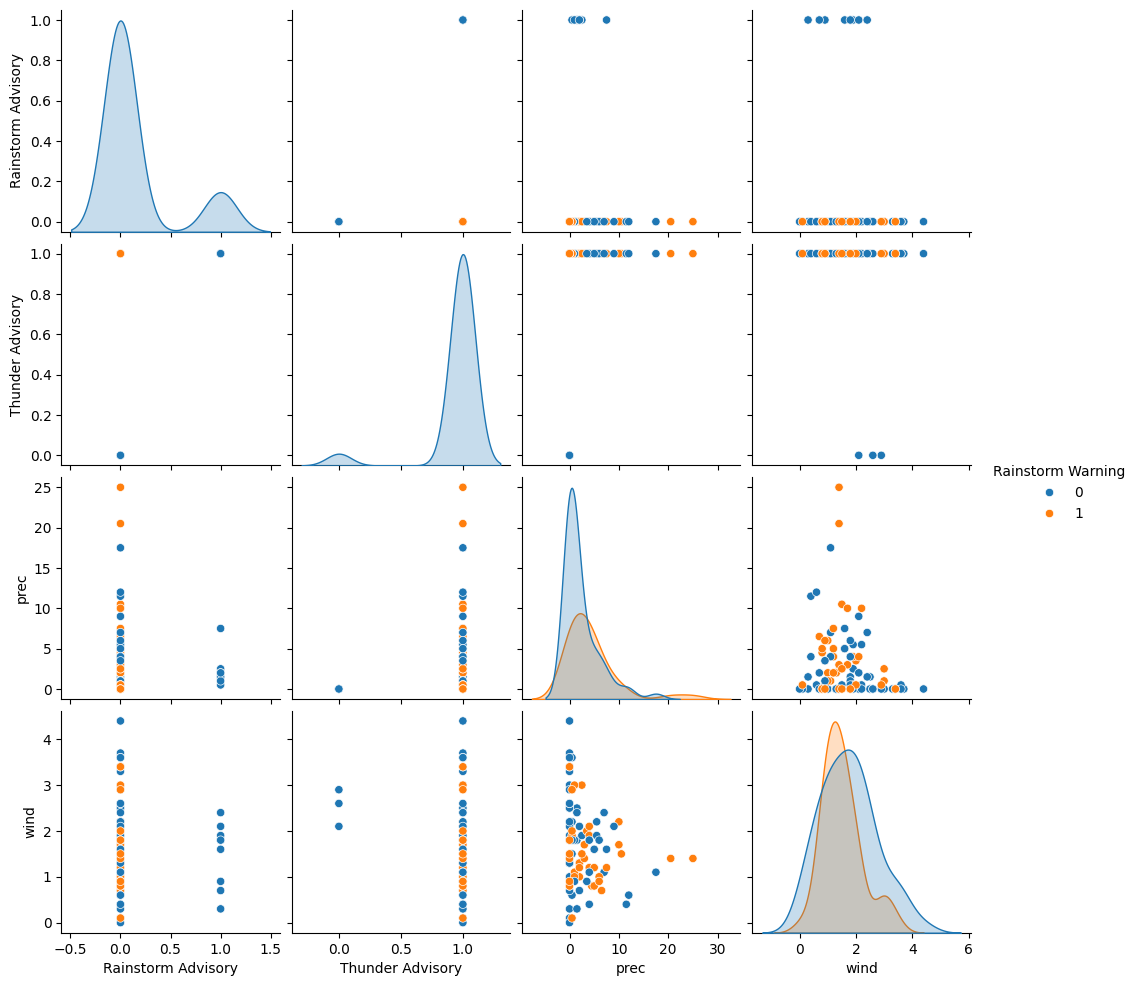

In [22]:
sns.pairplot(df_new,hue='Rainstorm Warning')

In [23]:
X = df_new[['Rainstorm Advisory','prec','wind','Thunder Advisory']]
# X = df_new
Y = df_new['Rainstorm Warning'] 
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=1)
lr=LogisticRegression()
lr.fit(X_train,Y_train)

LogisticRegression()

In [24]:
print('coefficient = ',lr.coef_)
print('intercept = ', lr.intercept_)

Y_pred = lr.predict(X_test)
print(Y_pred)
# print(Y_test)


coefficient =  [[-1.13401747  0.08545499 -0.13772913  0.66493797]]
intercept =  [-0.90716187]
[0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0]


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('confusion matrix = \n', confusion_matrix(y_true=Y_test, y_pred=Y_pred))
print('accuracy = ', accuracy_score(y_true=Y_test, y_pred=Y_pred))
print('precision = ', precision_score(y_true=Y_test, y_pred=Y_pred))
print('recall = ', recall_score(y_true=Y_test, y_pred=Y_pred))
print('f1 score = ', f1_score(y_true=Y_test, y_pred=Y_pred))

confusion matrix = 
 [[11  2]
 [ 4  3]]
accuracy =  0.7
precision =  0.6
recall =  0.42857142857142855
f1 score =  0.5


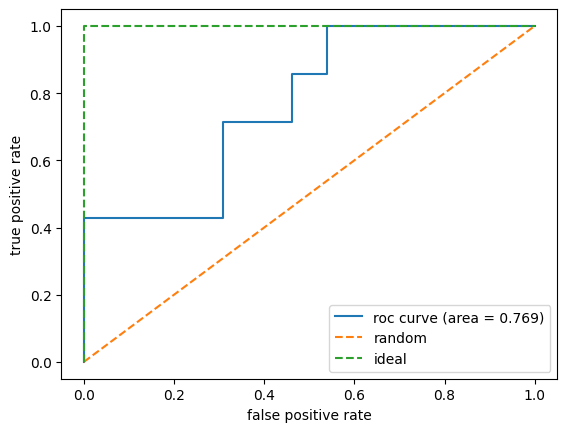

In [26]:
from sklearn.metrics import roc_curve, auc

Y_score = lr.predict_proba(X_test)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=Y_test, y_score=Y_score)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
